In [9]:
!source /etc/profile.d/modules.sh
!module load CUDA/11.2
!export PATH=/local/java/cuda-11.2/bin:$PATH
!export LD_LIBRARY_PATH=/local/java/cuda-11.2/lib64:/local/java/cudnn-8.1_for_cuda_11.2/lib64:$LD_LIBRARY_PATH  # this line is needed for it to recognise gpu devices -- run this in the terminal
!export CUDA_HOME=/local/java/cuda-11.2
!/local/java/cuda-11.2/bin/nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:08:53_PST_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0
Sun Feb  9 17:48:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
|  0%   39C    P5       

In [10]:
import os 
import tensorflow as tf

import matplotlib.pyplot as plt 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Lambda

from keras import backend as K

print(tf.__version__)  # 2.12.0
print(tf.config.list_physical_devices('GPU'))  # should show gpu available


2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Get images as (anchor, second_image, label)
1 if second image is positive, 0 if negative

In [11]:
TRAIN_PATH = "train"
TEST_PATH = "test"

positive_pairs_train = []
negative_pairs_train = []


"""
from natsort import natsorted, ns
org_signs = os.listdir(os.path.join(TRAIN_PATH, "full_org"))
forg_signs = os.listdir(os.path.join(TRAIN_PATH, "full_forg"))
org_signs = natsorted(org_signs, alg=ns.IGNORECASE)
forg_signs = natsorted(forg_signs, alg=ns.IGNORECASE)

positive_dir = os.path.join(TRAIN_PATH, "full_org")
negative_dir = os.path.join(TRAIN_PATH, "full_forg")

# splits into chunks of 24 
for i in range(0, len(org_signs), 24):
    # anchor is the first image 
    anchor = os.path.join(positive_dir, org_signs[i])

    # iterate over the 23 images left
    for j in range(i+1, i+24):
        positive = os.path.join(positive_dir, org_signs[j])
        positive_pairs_train.append((anchor, positive, 1))

    # then iterate over the 24 images of the forged ones 
    for k in range(i, i+24):
        negative = os.path.join(negative_dir, forg_signs[k])
        if negative.endswith(".png"):
            negative_pairs_train.append((anchor, negative, 0))

data_raw_train = positive_pairs_train + negative_pairs_train 
data_raw_train
"""

'\nfrom natsort import natsorted, ns\norg_signs = os.listdir(os.path.join(TRAIN_PATH, "full_org"))\nforg_signs = os.listdir(os.path.join(TRAIN_PATH, "full_forg"))\norg_signs = natsorted(org_signs, alg=ns.IGNORECASE)\nforg_signs = natsorted(forg_signs, alg=ns.IGNORECASE)\n\npositive_dir = os.path.join(TRAIN_PATH, "full_org")\nnegative_dir = os.path.join(TRAIN_PATH, "full_forg")\n\n# splits into chunks of 24 \nfor i in range(0, len(org_signs), 24):\n    # anchor is the first image \n    anchor = os.path.join(positive_dir, org_signs[i])\n\n    # iterate over the 23 images left\n    for j in range(i+1, i+24):\n        positive = os.path.join(positive_dir, org_signs[j])\n        positive_pairs_train.append((anchor, positive, 1))\n\n    # then iterate over the 24 images of the forged ones \n    for k in range(i, i+24):\n        negative = os.path.join(negative_dir, forg_signs[k])\n        if negative.endswith(".png"):\n            negative_pairs_train.append((anchor, negative, 0))\n\ndata_ra

In [12]:

# Anchor images are in train/directory/anchor for each directory
for category in os.listdir(TRAIN_PATH):
    anchor_dir = os.path.join(TRAIN_PATH, category, "anchor")
    positive_dir = os.path.join(TRAIN_PATH, category, "positive")
    negative_dir = os.path.join(TRAIN_PATH, category, "negative")

    anchor_list = [os.path.join(anchor_dir, f) for f in os.listdir(anchor_dir)]
    positive_list = [os.path.join(positive_dir, f) for f in os.listdir(positive_dir)]
    negative_list = [os.path.join(negative_dir, f) for f in os.listdir(negative_dir)]

    # Within each category directory, match each anchor with each positive and negative 
    positive_pairs_train += [(a, p, 1) for a in anchor_list for p in positive_list]
    negative_pairs_train += [(a, n, 0) for a in anchor_list for n in negative_list]

data_raw_train = positive_pairs_train + negative_pairs_train 
data_raw_train

[('train/pencil_case/anchor/20250204_193242.jpg',
  'train/pencil_case/positive/20250204_203128.jpg',
  1),
 ('train/pencil_case/anchor/20250204_193242.jpg',
  'train/pencil_case/positive/20250204_202623.jpg',
  1),
 ('train/pencil_case/anchor/20250204_193242.jpg',
  'train/pencil_case/positive/20250204_193312.jpg',
  1),
 ('train/pencil_case/anchor/20250204_193301.jpg',
  'train/pencil_case/positive/20250204_203128.jpg',
  1),
 ('train/pencil_case/anchor/20250204_193301.jpg',
  'train/pencil_case/positive/20250204_202623.jpg',
  1),
 ('train/pencil_case/anchor/20250204_193301.jpg',
  'train/pencil_case/positive/20250204_193312.jpg',
  1),
 ('train/pencil_case/anchor/LL83529-PN_Lihit-Lab-Lying-Pen-Pouch-PuniLabo-Penguin_P3.jpg',
  'train/pencil_case/positive/20250204_203128.jpg',
  1),
 ('train/pencil_case/anchor/LL83529-PN_Lihit-Lab-Lying-Pen-Pouch-PuniLabo-Penguin_P3.jpg',
  'train/pencil_case/positive/20250204_202623.jpg',
  1),
 ('train/pencil_case/anchor/LL83529-PN_Lihit-Lab-Lying

In [13]:
# Do the same for test images
positive_pairs_test = []
negative_pairs_test = []

test_path_positive = os.path.join(TEST_PATH, "positive")
test_path_negative = os.path.join(TEST_PATH, "negative")

for category in os.listdir(test_path_positive):
    dirs = os.listdir(os.path.join(test_path_positive, category))
    first_dir = os.path.join(test_path_positive, category, dirs[0])
    second_dir = os.path.join(test_path_positive, category, dirs[1])
    positive_pairs_test.append((category, first_dir, second_dir, 1))

for category in os.listdir(test_path_negative):
    dirs = os.listdir(os.path.join(test_path_negative, category))
    first_dir = os.path.join(test_path_negative, category, dirs[0])
    second_dir = os.path.join(test_path_negative, category, dirs[1])
    negative_pairs_test.append((category, first_dir, second_dir, 0))

data_raw_test = positive_pairs_test + negative_pairs_test

data_raw_test

[('mouse_untrained_positive',
  'test/positive/mouse_untrained_positive/20250131_014405.jpg',
  'test/positive/mouse_untrained_positive/20250129_125729.jpg',
  1),
 ('earbuds_untrained_different_environment',
  'test/positive/earbuds_untrained_different_environment/20250131_030121.jpg',
  'test/positive/earbuds_untrained_different_environment/20250131_030103.jpg',
  1),
 ('light_untrained_positive',
  'test/positive/light_untrained_positive/20250131_025753.jpg',
  'test/positive/light_untrained_positive/20250131_025818.jpg',
  1),
 ('power_bank_trained',
  'test/positive/power_bank_trained/s-l1200.jpg',
  'test/positive/power_bank_trained/20250204_204406.jpg',
  1),
 ('pen_trained_positive',
  'test/positive/pen_trained_positive/20250131_014147.jpg',
  'test/positive/pen_trained_positive/20250131_014155.jpg',
  1),
 ('stand_untrained_different_image_size',
  'test/positive/stand_untrained_different_image_size/20250131_030323.jpg',
  'test/positive/stand_untrained_different_image_size/2

# Preprocess images

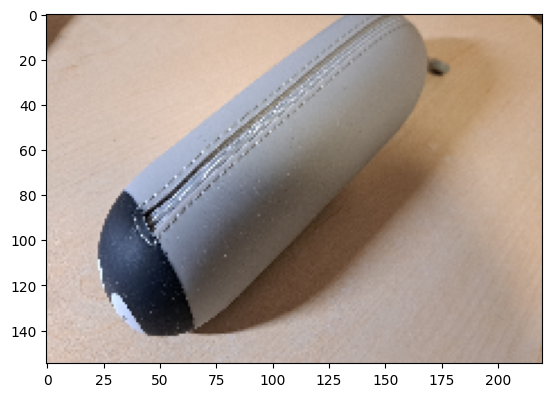

In [14]:
def preprocess(image_path):
    byte_img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, (155, 220))  # Resize to 105x105
    img = img[:, :, :3]  # Keep 3 channels
    img = img / 255.0  # Scale image between 0 and 1
    return img 

# The first anchor image is shown
test = preprocess(data_raw_train[0][0])
plt.imshow(test)

# Create labelled dataset (1 and 0)

In [15]:

# Convert to tf dataset 
def convert_to_tf_dataset(data_raw):
    i1_paths, i2_paths, labels = zip(*data_raw)
    i1_dataset = tf.data.Dataset.from_tensor_slices(list(i1_paths)).map(preprocess)  # Preprocess the images 
    i2_dataset = tf.data.Dataset.from_tensor_slices(list(i2_paths)).map(preprocess)
    label_dataset = tf.data.Dataset.from_tensor_slices(list(labels))

    dataset = tf.data.Dataset.zip((i1_dataset, i2_dataset, label_dataset))
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1024)

    return dataset

0


<ShuffleDataset element_spec=(TensorSpec(shape=(155, 220, 3), dtype=tf.float32, name=None), TensorSpec(shape=(155, 220, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

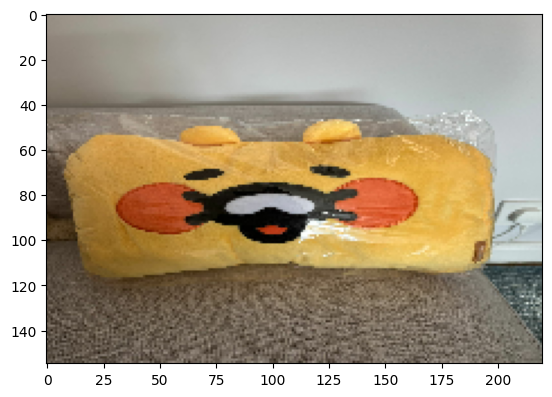

In [16]:
# Convert to tf dataset 
dataset_train = convert_to_tf_dataset(data_raw_train)

# Check 
samples = dataset_train.as_numpy_iterator()
next = samples.next()
print(next[2])  # next[0] is the anchor, next[1] is the positive, next[2] is the negative
# Hence, if 1 is printed, the image is positive, else the image should be negative:
plt.imshow(next[1])

# Should show a different image everytime 
dataset_train  

# Create the train_data

In [17]:
# Number of anchors in each anchor dir * (Number of positives in each positive dir + Number of negatives in each negative dir) * Number of categories
print(len(dataset_train))

BATCH_SIZE = 16

# Split the train dataset into train data (7) and validation data (3)
train_data = dataset_train.take(round(len(dataset_train)*.7))  # Take all train data
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(8)

validation_data = dataset_train.skip(round(len(dataset_train)*.7))
validation_data = validation_data.take(round(len(dataset_train)*.3))
validation_data = validation_data.batch(BATCH_SIZE)
validation_data = validation_data.prefetch(8)

# Print the length of train data and validation data
print(len(train_data))
print(len(validation_data))

# Check
train_sample = train_data.as_numpy_iterator().next()
print(train_data)
print(len(train_sample))  # 3
print(len(train_sample[0]))  # = BATCH_SIZE

569
25
11
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 155, 220, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 155, 220, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
3
16


# Build embedding layer

In [18]:

from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization, Input, Dropout, Flatten
def make_embedding():
  input = Input(shape=(155,220,3))
  
  conv_1 = Conv2D(filters=96, kernel_size=(11,11))(input)
  batch_norm_1 = BatchNormalization()(conv_1)
  activation_1 = Activation('relu')(batch_norm_1)
  max_pool_1 = MaxPooling2D(pool_size=(3,3))(activation_1)
  
  conv_2 = Conv2D(filters=256, kernel_size=(5,5))(max_pool_1)
  batch_norm_2 = BatchNormalization()(conv_2)
  activation_2 = Activation('relu')(batch_norm_2)
  max_pool_2 = MaxPooling2D(pool_size=(3,3))(activation_2)
  
  dropout_1 = Dropout(rate=0.3)(max_pool_2)
  
  conv_3_a = Conv2D(filters=384, kernel_size=(3,3))(dropout_1)
  activation_3_a = Activation('relu')(conv_3_a)
  conv_3_b = Conv2D(filters=256, kernel_size=(3,3))(activation_3_a)
  activation_3_b = Activation('relu')(conv_3_b)
  max_pool_3 = MaxPooling2D(pool_size=(3,3))(activation_3_b)
  
  dropout_2 = Dropout(rate=0.3)(max_pool_3)
  
  flat_1 = Flatten()(dropout_2)
  fc_1 = Dense(units=1024,activation='relu')(flat_1)
  dropout_3 = Dropout(rate=0.5)(fc_1)
  fc_2 = Dense(units=128,activation='relu')(dropout_3)
  return Model(input,fc_2)

# Create model
embedding = make_embedding()
embedding.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 155, 220, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 145, 210, 96)      34944     
                                                                 
 batch_normalization (BatchN  (None, 145, 210, 96)     384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 145, 210, 96)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 70, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 66, 256)       614656

# Build distance layer

In [19]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    # L1 distance (Similarity calculation)
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    
l1 = L1Dist()

# Make siamese model

In [20]:
LEARNING_RATE = 1e-4 
opt = tf.keras.optimizers.Adam(LEARNING_RATE)   # Learning rate = 0.001

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

MARGIN = 1
def contrastive_loss(y_true, y_pred):
    # y_pred is the euclidean distance between embeddings!
    y_true = K.cast(y_true, dtype="float32")
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(MARGIN-y_pred, 0))
    return K.mean(y_true*square_pred + (1-y_true)*margin_square)
    


In [21]:
def make_siamese_model():
    # Get the input images
    input_image = Input(name="input_img", shape=(155, 220, 3))
    validation_image = Input(name="validation_img", shape=(155, 220, 3))

    embedding_model = make_embedding()  # Create the embedding model once

    embedding1 = embedding_model(input_image)  # Pass the image through the model
    embedding2 = embedding_model(validation_image)

    # Compute Euclidean distance between embeddings
    distance = Lambda(euclidean_distance)([embedding1, embedding2])

    # Define the Siamese model
    siamese_model = Model(inputs=[input_image, validation_image], outputs=distance)

    # Compile the model with contrastive loss
    siamese_model.compile(loss=contrastive_loss, optimizer="adam")

    return siamese_model


# First goes through embedding (Hidden) layers, then passed to distance layer and finally dense (output) layer 
siamese_model = make_siamese_model()
siamese_model.summary()
    

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 155, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 155, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 128)          7271936     ['input_img[0][0]',              
                                                                  'validation_img[0][0]']   

# Set up loss and optimiser

# Establish checkpoints

In [22]:
checkpoint_dir = "training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)  # siamese_model is the model created above 


# Build train step function
used to train one batch of data

In [23]:
# siamese_model is the model created above 

# Compile this function into tensorflow graph (@tf.function)
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]  # [anchor, positive] or [anchor, negative]
        y = batch[2]   # The label (0 or 1)

        # Pass this to the siamese neural network 
        yhat = siamese_model(X, training=True)  # Predicted y, i.e. y-hat  (y^)
        
        # Calculate loss 
        loss = contrastive_loss(y, yhat)   # Defined in "set up loss and optimiser" - pass the y ground truth (label) and the predicted y value

    # Calculate gradients 
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and then apply to the siamese model
    opt.apply_gradients(
        zip(grad, siamese_model.trainable_variables)
    )

    # return the loss 
    return loss

# Set up tensorboard logging

In [24]:
import tensorflow as tf
from datetime import datetime

log_dir = "logs/" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# Create a summary writer
summary_writer = tf.summary.create_file_writer(log_dir)

# Set up precision and recall

In [25]:
# Import precision and recall 
from tensorflow.keras.metrics import Precision, Recall 

# Initialise precision and recall
precision = Precision()
recall = Recall()

# Build training loop

In [26]:
def train(train_data, val_data, EPOCHS):
    # For each epoch, loop through each batch and run train steps 
    step = 0
    for epoch in range(1, EPOCHS+1):

        print(f"Epoch {epoch} of {EPOCHS}" + "\n")
        progbar = tf.keras.utils.Progbar(len(train_data))

        # Loop through each batch
        # Train loop
        train_loss_average = tf.keras.metrics.Mean()
        for index, batch in enumerate(train_data):
            loss = train_step(batch)
            train_loss_average.update_state(loss)
            progbar.update(index + 1)

        # Val loop
        val_loss_average = tf.keras.metrics.Mean()
        precision_train = tf.keras.metrics.Precision()
        recall_train = tf.keras.metrics.Recall()
        for val_batch in val_data:
            # Calculate loss for the validation data
            X = val_batch[:2]  # [anchor, positive] or [anchor, negative]
            y = val_batch[2]   # The label (0 or 1)
            yhat = siamese_model(X, training=False)  # Predicted y, i.e. y-hat  (y^)
            yhat_binary = tf.cast(yhat > 0.5, tf.float32)  # Convert to 0 or 1

            # Calculate loss 
            loss = contrastive_loss(y, yhat)
            val_loss_average.update_state(loss)

            # Update precision and recall
            precision_train.update_state(y, yhat_binary)
            recall_train.update_state(y, yhat_binary)

        with summary_writer.as_default():
            tf.summary.scalar('train_loss', float(train_loss_average.result()), step=step)
            tf.summary.scalar('val_loss', float(val_loss_average.result()), step=step)
            tf.summary.scalar('precision', float(precision_train.result()), step=step)
            tf.summary.scalar('recall', float(recall_train.result()), step=step)

        step += 1
        
        # Save checkpoints 
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)  # "ckpt"


# Train the model

In [27]:
EPOCHS = 50

# Train model here 
train(train_data, validation_data, EPOCHS)

Epoch 1 of 50



2025-02-09 17:48:52.761927: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-02-09 17:48:53.176133: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-09 17:48:53.176508: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-09 17:48:53.176521: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2025-02-09 17:48:53.176852: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-09 17:48:53.176878: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-02-09 17:48:53.728475: I tensorflow/stream_executor/cuda/c

25/25 [==============================] - 9s 232ms/step
Epoch 2 of 50

25/25 [==============================] - 4s 154ms/step
Epoch 3 of 50

25/25 [==============================] - 4s 154ms/step
Epoch 4 of 50

25/25 [==============================] - 4s 153ms/step
Epoch 5 of 50

25/25 [==============================] - 4s 154ms/step
Epoch 6 of 50

25/25 [==============================] - 4s 153ms/step
Epoch 7 of 50

25/25 [==============================] - 4s 154ms/step
Epoch 8 of 50

25/25 [==============================] - 4s 153ms/step
Epoch 9 of 50

25/25 [==============================] - 4s 153ms/step
Epoch 10 of 50

25/25 [==============================] - 4s 155ms/step
Epoch 11 of 50

25/25 [==============================] - 4s 155ms/step
Epoch 12 of 50

25/25 [==============================] - 4s 154ms/step
Epoch 13 of 50

25/25 [==============================] - 4s 154ms/step
Epoch 14 of 50

25/25 [==============================] - 4s 155ms/step
Epoch 15 of 50

25/25 [=======

# Evaluate the model
precision: How many positive predictions are correct
recall: How many positive results are predicted correctly.

A higher number is a better performance

In [28]:
""" 
# Run the model on the test data 
for (test_image_1, test_image_2, label) in validation_data:
    # Make predictions and compare to ground truth
    yhat = siamese_model.predict([test_image_1, test_image_2]) 
    y_true = label

    # Postprocess them based on a threshold 
    THRESHOLD = 0.25 
    yhat_binary = yhat <= THRESHOLD

    print(f"Expected = {label}")
    print(f"Predicted: {yhat_binary}")
    print(f"Confidence: {yhat}")

    # Update the precision and recall value 
    precision.update_state(y_true, yhat_binary)
    recall.update_state(y_true, yhat_binary)
"""

' \n# Run the model on the test data \nfor (test_image_1, test_image_2, label) in validation_data:\n    # Make predictions and compare to ground truth\n    yhat = siamese_model.predict([test_image_1, test_image_2]) \n    y_true = label\n\n    # Postprocess them based on a threshold \n    THRESHOLD = 0.25 \n    yhat_binary = yhat <= THRESHOLD\n\n    print(f"Expected = {label}")\n    print(f"Predicted: {yhat_binary}")\n    print(f"Confidence: {yhat}")\n\n    # Update the precision and recall value \n    precision.update_state(y_true, yhat_binary)\n    recall.update_state(y_true, yhat_binary)\n'

In [29]:
# Run the model on the test data 
for (category, test_image_1, test_image_2, label) in data_raw_test:
    p1 = tf.expand_dims(preprocess(test_image_1), axis = 0)   # Make the batch size 1
    p2 = tf.expand_dims(preprocess(test_image_2), axis = 0)

    # Make predictions and compare to ground truth
    yhat = siamese_model.predict([p1, p2])
    y_true = tf.convert_to_tensor([label], dtype=tf.float32)

    # Postprocess them based on a threshold 
    THRESHOLD = 0.5 

    print(f"{category}")
    print(f"Expected = {label}")
    print(f"Predicted: {yhat >= THRESHOLD}")
    print(f"Confidence: {yhat}")

    # Update the precision and recall value 
    precision.update_state(y_true, yhat)
    recall.update_state(y_true, yhat)

1/1 [==============================] - 0s 237ms/step
mouse_untrained_positive
Expected = 1
Predicted: [[False]]
Confidence: [[0.06702609]]
1/1 [==============================] - 0s 12ms/step
earbuds_untrained_different_environment
Expected = 1
Predicted: [[False]]
Confidence: [[0.07414053]]
1/1 [==============================] - 0s 13ms/step
light_untrained_positive
Expected = 1
Predicted: [[False]]
Confidence: [[0.13482787]]
1/1 [==============================] - 0s 12ms/step
power_bank_trained
Expected = 1
Predicted: [[False]]
Confidence: [[0.09180918]]
1/1 [==============================] - 0s 13ms/step
pen_trained_positive
Expected = 1
Predicted: [[False]]
Confidence: [[0.09840715]]
1/1 [==============================] - 0s 12ms/step
stand_untrained_different_image_size
Expected = 1
Predicted: [[False]]
Confidence: [[0.081232]]
1/1 [==============================] - 0s 12ms/step
mouse_untrained_negative
Expected = 0
Predicted: [[False]]
Confidence: [[0.06573214]]
1/1 [=============

In [30]:
print(f"Precision: {precision.result().numpy()}")
print(f"Recall: {recall.result().numpy()}")

Precision: 0.0
Recall: 0.0


# Save and load the model to the "model" variable

In [31]:
MODEL_OUTPUT_NAME = "siameseModel"

siamese_model.save(MODEL_OUTPUT_NAME + ".h5")

In [32]:
# Reload the model:
model = tf.keras.models.load_model(MODEL_OUTPUT_NAME + ".h5", 
                                   custom_objects={
                                       "euclidean_distance": euclidean_distance,    # From "Build distance layer" - it is a custom layer in = L1Dist()
                                       "contrastive_loss": contrastive_loss
                                       }
                                   )

# Output the model as .tflite file
this may take a while

In [33]:
"""
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_filename = MODEL_OUTPUT_NAME + ".tflite"
with open(tflite_filename, "wb") as f:
    f.write(tflite_model)
"""


'\nimport tensorflow as tf\n\nconverter = tf.lite.TFLiteConverter.from_keras_model(model)\ntflite_model = converter.convert()\ntflite_filename = MODEL_OUTPUT_NAME + ".tflite"\nwith open(tflite_filename, "wb") as f:\n    f.write(tflite_model)\n'